In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

2022-11-27 22:12:04.459439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 22:12:05.052541: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-27 22:12:05.052586: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-27 22:12:05.052590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT librar

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

import jax
import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax
from jax.example_libraries import stax as ostax
from flax.training.checkpoints import restore_checkpoint

import tensorflow_datasets as tfds

/home/pc3090/miniconda3/envs/jax/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(42)

In [4]:
NUM_CLASSES = 10
SEED = 42

In [5]:
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024, seed=42)
train_ds, test_ds = tfds.load('mnist:3.*.*', split=['train[:80%]', 'train[80%:]'])

def preprocess(x):
    image, label = x['image'], x['label']
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.reshape(image, (-1,))
    # label = 1 if label % 2 == 0 else 0
    label = int(label)
    return image, label

train_ds = train_ds.map(preprocess).as_numpy_iterator()
test_ds = test_ds.map(preprocess).as_numpy_iterator()

def load_x_y(ds):
    x_list, y_list = [], []
    for x, y in ds:
        x = x / np.linalg.norm(x)
        y = np.eye(NUM_CLASSES)[y]
        x_list.append(x)
        y_list.append(y)
    return np.stack(x_list, axis=0), np.stack(y_list, axis=0)

train_x, train_y = load_x_y(train_ds)
test_x, test_y = load_x_y(test_ds)

In [6]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(48000, 784) (12000, 784) (48000, 10) (12000, 10)


In [7]:
train_length = 20000
test_length = 10000
inds = np.random.randint(0, train_x.shape[0], train_length)
train_x = train_x[inds]
train_y = train_y[inds]
inds = np.random.randint(0, test_x.shape[0], test_length)
test_x = test_x[inds]
test_y = test_y[inds]

test_x_copy = test_x.copy()

In [8]:
def ntk_adv(num_iter=10, epsilon=1e-3, plot=True):

    _,_,kernel_fn = stax.serial(stax.Dense(1024), stax.Relu(), stax.Dense(1))
    kernel_fn = jax.jit(kernel_fn, static_argnums=(2,))

    K_train = kernel_fn(train_x, train_x, 'ntk')
    K_inv = jnp.linalg.inv(K_train + K_train.shape[0] * 1e-8 * jnp.eye(K_train.shape[0]))

    def predict(x_test):
        K_new = kernel_fn(train_x, x_test, 'ntk')
        return K_new.T @ K_inv @ train_y

    def loss_fn(test_x, test_y):
        pred = predict(x_test=test_x)
        loss = (0.5 * (pred - test_y) ** 2).mean()
        return loss

    def evaluate(test_x, test_y):
        pred = predict(x_test=test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    def update(test_x, test_y):
        grad = jax.grad(loss_fn)(test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv
    
    def plot_grid(x, before=None, after=None):
        cnt = 0
        ncol, nrow = 5, 2
        for i in range(ncol * nrow):
            cnt += 1
            plt.subplot(nrow, ncol, cnt)
            if before is not None and after is not None:
                plt.title(f"{before['pred'][i]} -> {after['pred'][i]}")
            plt.imshow(x[i].reshape(28, 28, 1))
        plt.show()
        plt.close()
    
    x = test_x_copy.copy()
    if plot:
        plot_grid(x[:10])
    
    pred, acc = evaluate(x, test_y)
    before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    acc_list = [acc]
    for step in tqdm(range(num_iter)):
        x = update(x, test_y)
        _, acc = evaluate(x, test_y)
        acc_list.append(acc)

    pred, acc = evaluate(x, test_y)
    after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    if plot:
        plt.plot(acc_list)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.ylim(0, 1)
        plt.grid()
        plt.show()
        plt.close()

    if plot:
        plot_grid(x[:10], before, after)

    print(f'Accuracy: {before["acc"]} -> {after["acc"]}')
    del K_train, K_inv
    return acc_list
    

2022-11-27 22:12:16.163617: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:492] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


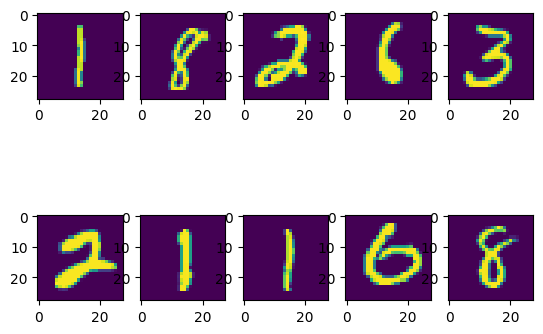

100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


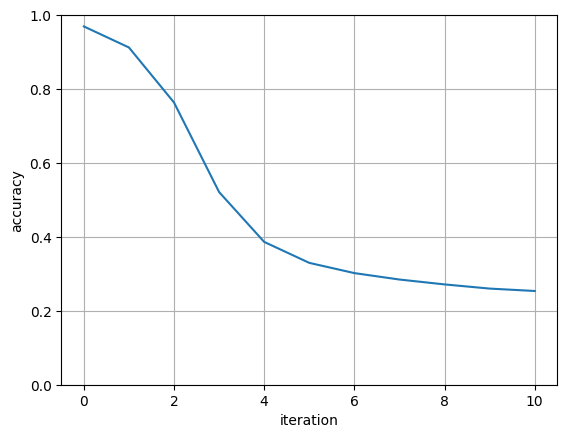

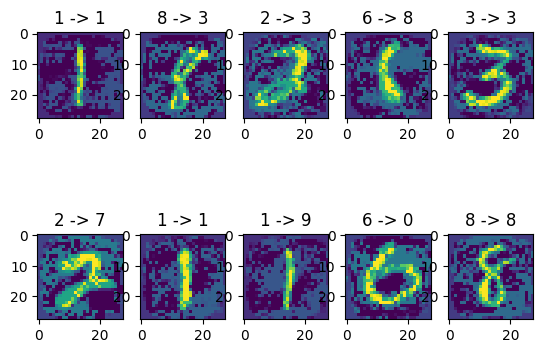

Accuracy: 0.9693999886512756 -> 0.25360000133514404


In [9]:
acc_list_ntk = ntk_adv(epsilon=3e-3)

In [10]:
def gauss_adv(num_iter=10, epsilon=1e-3, plot=True):
    @jax.jit
    def kernel_fn(x, y, theta1=1., theta2=1.):
        k = (
            jnp.sum(jnp.square(x), axis=1).reshape(-1, 1)
            + jnp.sum(jnp.square(y), axis=1)
            - 2 * x @ y.T
        )
        return theta1 * jnp.exp(-0.5 / theta2 * k)

    K_train = jax.device_get(kernel_fn(train_x, train_x))
    K_inv = jnp.linalg.inv(K_train + K_train.shape[0] * 1e-5 * jnp.eye(K_train.shape[0]))
    del K_train

    @jax.jit
    def predict(x_test):
        K_new = kernel_fn(train_x, x_test)
        return K_new.T @ K_inv @ train_y

    @jax.jit
    def loss_fn(test_x, test_y):
        pred = predict(x_test=test_x)
        loss = (0.5 * (pred - test_y) ** 2).mean()
        return loss

    @jax.jit
    def evaluate(test_x, test_y):
        pred = predict(x_test=test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    @jax.jit
    def update(test_x, test_y):
        grad = jax.grad(loss_fn)(test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv
    
    def plot_grid(x, before=None, after=None):
        cnt = 0
        ncol, nrow = 5, 2
        for i in range(ncol * nrow):
            cnt += 1
            plt.subplot(nrow, ncol, cnt)
            if before is not None and after is not None:
                plt.title(f"{before['pred'][i]} -> {after['pred'][i]}")
            plt.imshow(x[i].reshape(28, 28, 1))
        plt.show()
        plt.close()
    
    x = test_x_copy.copy()
    if plot:
        plot_grid(x[:10])
    
    pred, acc = evaluate(x, test_y)
    before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    acc_list = [acc]
    for step in tqdm(range(num_iter)):
        x = update(x, test_y)
        _, acc = evaluate(x, test_y)
        acc_list.append(acc)

    pred, acc = evaluate(x, test_y)
    after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    if plot:
        plt.plot(acc_list)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.ylim(0, 1)
        plt.grid()
        plt.show()
        plt.close()

    if plot:
        plot_grid(x[:10], before, after)

    print(f'Accuracy: {before["acc"]} -> {after["acc"]}')
    del K_inv
    return acc_list
    

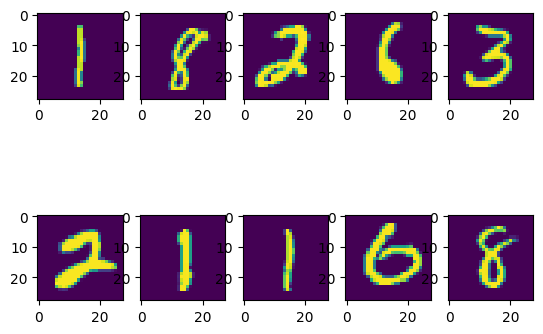

100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


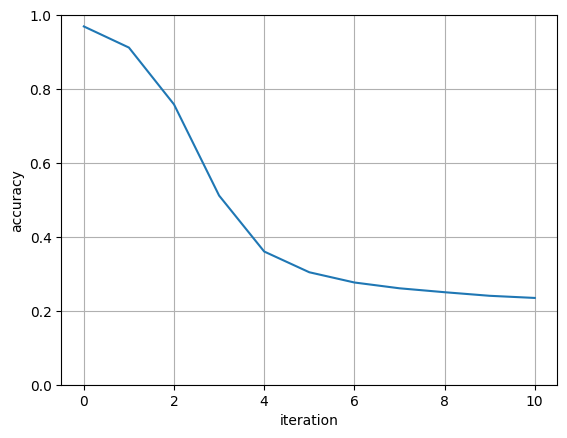

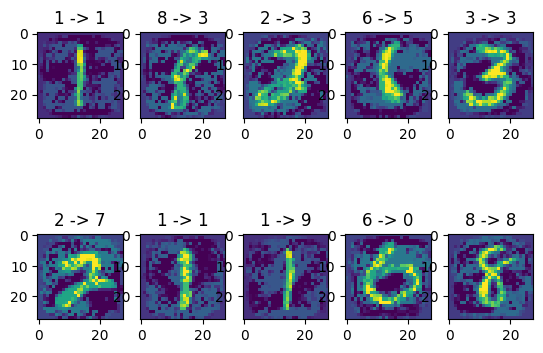

Accuracy: 0.9693999886512756 -> 0.23479999601840973


In [11]:
acc_list_gauss = gauss_adv(epsilon=3e-3)